**Goal**

Predict the total energy consumption in kBtu of buildings in Seattle.

In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data_science_functions as ds
import project_tools as pt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import QuantileTransformer
identity_transformer = FunctionTransformer(
    func=lambda x: x, inverse_func=lambda x: x, validate=True
)

from sklearn.pipeline import Pipeline

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

from math import sqrt
sns.set_style("ticks")

In [2]:
data = pd.read_csv("seattle.csv", index_col="OSEBuildingID")
display(data.head())
data.shape

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,Age,ProportionPrincipalUseType,ProportionSecondaryUseType,ProportionThirdUseType,RiseType,AgeType,energies_sum,energy_ratio,SteamUseProportion,ElectricityProportion,NaturalGasProportion
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,3946027.0,1276453.0,Compliant,NaN,249.98,2.83,96,1.000000,NaN,NaN,Medium,Very_old,7226362.00,1.0,0.28,0.55,0.18
2,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,3242851.0,5145082.0,Compliant,NaN,295.86,2.86,27,0.809918,0.145453,0.044629,Medium,Modern,8387933.00,1.0,0.00,0.39,0.61
3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,49526664.0,1493800.0,Compliant,NaN,2089.28,2.19,54,0.791220,NaN,NaN,High,Old,72587018.00,1.0,0.30,0.68,0.02
5,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,2768924.0,1811213.0,Compliant,NaN,286.43,4.67,97,1.000000,NaN,NaN,Medium,Very_old,6794583.25,1.0,0.33,0.41,0.27
8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,5368607.0,8803998.0,Compliant,NaN,505.01,2.88,43,0.703070,0.387339,0.000000,Medium,Modern,14172605.00,1.0,0.00,0.38,0.62


(1484, 51)

In [3]:
# Constant used as target in this notebook.
pt.ENERGY_TARGET

'SiteEnergyUse(kBtu)'

**Table of contents**<a id='toc0_'></a>    
- 1. [One-Hot Encoding](#toc1_)    
  - 1.1. [Primary Property Type](#toc1_1_)    
  - 1.2. [Council District Code](#toc1_2_)    
- 2. [Groups of features](#toc2_)    
- 3. [Preparing the target and visualizing some transformations.](#toc3_)    
- 4. [Splitting into test and train sets](#toc4_)    
- 5. [Defining metrics](#toc5_)    
- 6. [Baseline](#toc6_)    
- 7. [Defining pre_processors](#toc7_)    
- 8. [Linear regressions](#toc8_)    
  - 8.1. [OLS minimization](#toc8_1_)    
    - 8.1.1. [Without target transformation](#toc8_1_1_)    
      - 8.1.1.1. [With a simple MinMaxScaler for all numerical input features](#toc8_1_1_1_)    
      - 8.1.1.2. [With a simple Standard scaler for all numerical input features  and no target transformation](#toc8_1_1_2_)    
      - 8.1.1.3. [With a log-transformation on skewed input prior to MinMaxScaler](#toc8_1_1_3_)    
  - 8.2. [With target transformation](#toc8_2_)    
  - 8.3. [Lasso](#toc8_3_)    
  - 8.4. [Ridge](#toc8_4_)    
  - 8.5. [Elastic-net](#toc8_5_)    
- 9. [Model evaluation](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>One-Hot Encoding

## 1.1.  [&#9650;](#toc0_) <a id='toc1_1_'></a>Primary Property Type

In [4]:
# Formatting PPT
print("PRE-FORMATTING :\n")
display(data[pt.PPT].value_counts())
data[pt.PPT] = data[pt.PPT].str.split(" |/|-").str.join("")
print("POST-FORMATTING :\n")
display(data[pt.PPT].value_counts())

PRE-FORMATTING :



Small- and Mid-Sized Office    275
Other                          232
Warehouse                      182
Large Office                   164
Mixed Use Property              98
Retail Store                    82
Hotel                           73
Worship Facility                68
Distribution Center             53
K-12 School                     50
Medical Office                  37
Supermarket / Grocery Store     37
Self-Storage Facility           28
University                      24
Senior Care Community           20
Residence Hall                  20
Refrigerated Warehouse          11
Restaurant                      11
Hospital                         9
Laboratory                       8
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

POST-FORMATTING :



SmallandMidSizedOffice     275
Other                      232
Warehouse                  182
LargeOffice                164
MixedUseProperty            98
RetailStore                 82
Hotel                       73
WorshipFacility             68
DistributionCenter          53
K12School                   50
MedicalOffice               37
SupermarketGroceryStore     37
SelfStorageFacility         28
University                  24
SeniorCareCommunity         20
ResidenceHall               20
RefrigeratedWarehouse       11
Restaurant                  11
Hospital                     9
Laboratory                   8
LowRiseMultifamily           2
Name: PrimaryPropertyType, dtype: int64

In [5]:
data.loc[data[pt.PPT] == "LowRiseMultifamily", ["LargestPropertyUseType"]]

,LargestPropertyUseType
OSEBuildingID,
19445,Multifamily Housing
21481,Multifamily Housing


In [6]:
data = data.drop(data.loc[data[pt.PPT] == "LowRiseMultifamily"].index, axis=0)
display(data[pt.PPT].value_counts())

SmallandMidSizedOffice     275
Other                      232
Warehouse                  182
LargeOffice                164
MixedUseProperty            98
RetailStore                 82
Hotel                       73
WorshipFacility             68
DistributionCenter          53
K12School                   50
MedicalOffice               37
SupermarketGroceryStore     37
SelfStorageFacility         28
University                  24
SeniorCareCommunity         20
ResidenceHall               20
RefrigeratedWarehouse       11
Restaurant                  11
Hospital                     9
Laboratory                   8
Name: PrimaryPropertyType, dtype: int64

In [7]:
PPT_encoder, data = ds.one_hot_encoding(data, [pt.PPT], drop="first")

## 1.2.  [&#9650;](#toc0_) <a id='toc1_2_'></a>Council District Code

In [8]:
data.CouncilDistrictCode.value_counts()

7    489
2    357
3    174
4    154
5    115
6     99
1     94
Name: CouncilDistrictCode, dtype: int64

In [9]:
geo_encoder, data = ds.one_hot_encoding(
    data, ["CouncilDistrictCode"], drop="first"
)
data.shape

(1482, 76)

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Defining groups of features and plotting some inputs transformations.

In [10]:
# Check one hot encoded features names
data.columns[-25:]

Index(['PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K12School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_LargeOffice', 'PrimaryPropertyType_MedicalOffice',
       'PrimaryPropertyType_MixedUseProperty', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_RefrigeratedWarehouse',
       'PrimaryPropertyType_ResidenceHall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_RetailStore',
       'PrimaryPropertyType_SelfStorageFacility',
       'PrimaryPropertyType_SeniorCareCommunity',
       'PrimaryPropertyType_SmallandMidSizedOffice',
       'PrimaryPropertyType_SupermarketGroceryStore',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_WorshipFacility', 'CouncilDistrictCode_2',
       'CouncilDistrictCode_3', 'CouncilDistrictCode_4',
       'CouncilDistrictCode_5', 'CouncilDistrictCode_6',
       'CouncilDistrictCode_7'],
      dtype='object')

In [11]:
# Preparing groups of features for later convenience
PPT_categories = PPT_encoder.categories_[0]
PPT_fts = ["PrimaryPropertyType_" + cat for cat in PPT_categories[1:]]

geo_categories = geo_encoder.categories_[0]
geo_fts = ["CouncilDistrictCode_" + str(cat) for cat in geo_categories[1:]]

num_fts = [
    "PropertyGFABuilding(s)",
    "Age",
    "NumberofBuildings",
    "NumberofFloors",
    "SteamUseProportion",
    "ElectricityProportion",
    "NaturalGasProportion",
]

core_fts = [*num_fts, *PPT_fts]

additional_fts = [*geo_fts, "ProportionPrincipalUseType"]

In [12]:
core_fts

['PropertyGFABuilding(s)',
 'Age',
 'NumberofBuildings',
 'NumberofFloors',
 'SteamUseProportion',
 'ElectricityProportion',
 'NaturalGasProportion',
 'PrimaryPropertyType_Hospital',
 'PrimaryPropertyType_Hotel',
 'PrimaryPropertyType_K12School',
 'PrimaryPropertyType_Laboratory',
 'PrimaryPropertyType_LargeOffice',
 'PrimaryPropertyType_MedicalOffice',
 'PrimaryPropertyType_MixedUseProperty',
 'PrimaryPropertyType_Other',
 'PrimaryPropertyType_RefrigeratedWarehouse',
 'PrimaryPropertyType_ResidenceHall',
 'PrimaryPropertyType_Restaurant',
 'PrimaryPropertyType_RetailStore',
 'PrimaryPropertyType_SelfStorageFacility',
 'PrimaryPropertyType_SeniorCareCommunity',
 'PrimaryPropertyType_SmallandMidSizedOffice',
 'PrimaryPropertyType_SupermarketGroceryStore',
 'PrimaryPropertyType_University',
 'PrimaryPropertyType_Warehouse',
 'PrimaryPropertyType_WorshipFacility']

In [13]:
additional_fts

['CouncilDistrictCode_2',
 'CouncilDistrictCode_3',
 'CouncilDistrictCode_4',
 'CouncilDistrictCode_5',
 'CouncilDistrictCode_6',
 'CouncilDistrictCode_7',
 'ProportionPrincipalUseType']

I might want to come back here, and try to weight the ones of PPT with its proportion.

For that, I might need to map each largest use type(more detailed) with primary type.

And I could do the same with second and third largest use type.

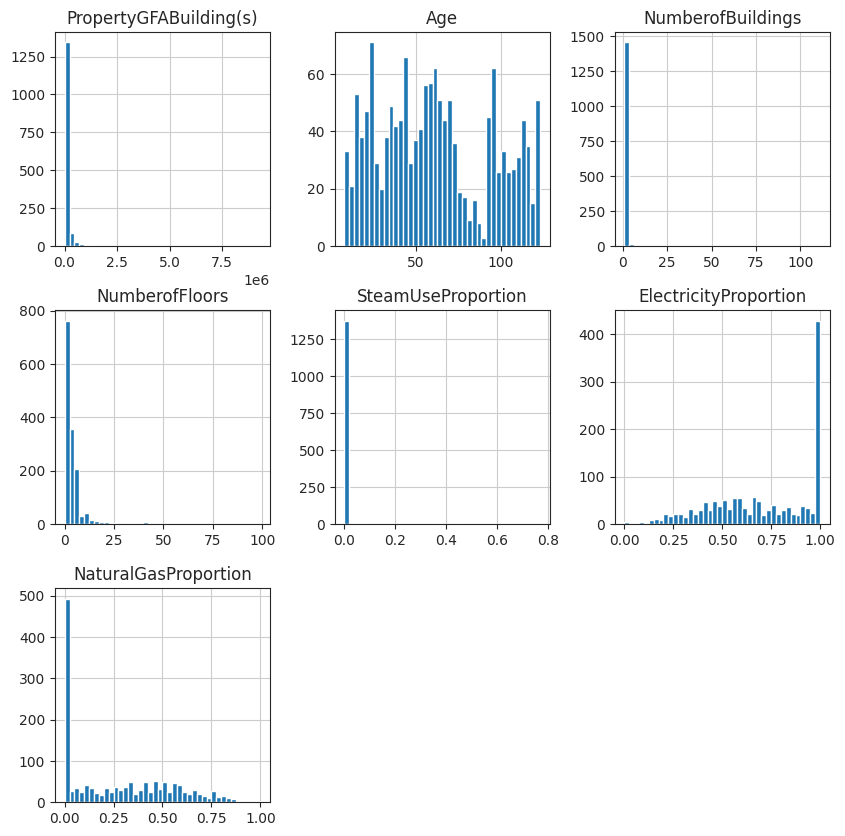

skewness :


PropertyGFABuilding(s)    21.469276
Age                        0.276967
NumberofBuildings         30.938935
NumberofFloors             5.888723
SteamUseProportion         4.485547
ElectricityProportion     -0.354307
NaturalGasProportion       0.514989
dtype: float64

In [14]:
data.hist(num_fts, bins=40, figsize=(10,10))
plt.show()
print("skewness :")
data[num_fts].skew()

Skewed features can be improved.

In [15]:
skewed_fts = (data[num_fts].skew().to_frame()
              .rename(columns={0: "skew"})
              .query("skew > 1")
              .index)

skewed_fts

Index(['PropertyGFABuilding(s)', 'NumberofBuildings', 'NumberofFloors',
       'SteamUseProportion'],
      dtype='object')

In [16]:
log_inputs = np.log1p(data[skewed_fts])

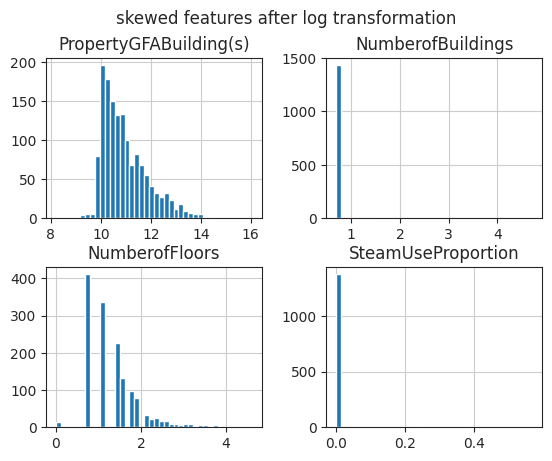

PropertyGFABuilding(s)    1.151732
NumberofBuildings         9.088150
NumberofFloors            1.264494
SteamUseProportion        4.271994
dtype: float64

In [17]:
log_inputs.hist(bins=40)
plt.suptitle("skewed features after log transformation")
plt.show()
log_inputs.skew()

May be I could also apply a log transformation followed by a MinMaxscaler.

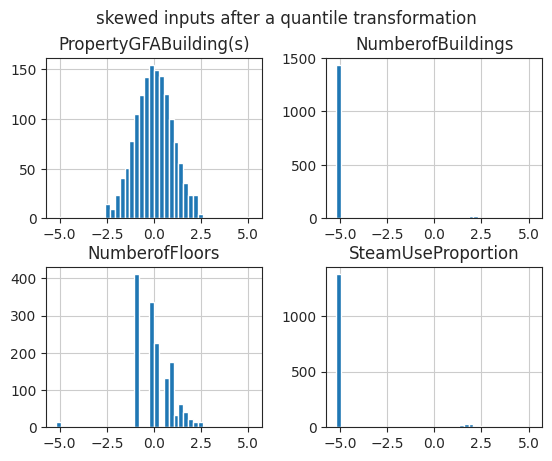

PropertyGFABuilding(s)   -0.013578
NumberofBuildings         5.154727
NumberofFloors           -0.813804
SteamUseProportion        3.280278
dtype: float64

In [18]:
qtn = QuantileTransformer(
    n_quantiles=100, output_distribution="normal", random_state=0
)
qt_inputs = pd.DataFrame(
    qtn.fit_transform(data[skewed_fts]),
    columns=skewed_fts
)

qt_inputs.hist(bins=40)
plt.suptitle('skewed inputs after a quantile transformation')
plt.show()
qt_inputs.skew()

In [19]:
# qtn = RobustScaler(
#     
# )
# robust_inputs = pd.DataFrame(
#     qtn.fit_transform(data[skewed_fts]),
#     columns=skewed_fts
# )

# qt_inputs.hist(bins=40)
# plt.suptitle('skewed inputs after a quantile transformation')
# plt.show()
# qt_inputs.skew()

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Preparing the target and visualizing some transformations.

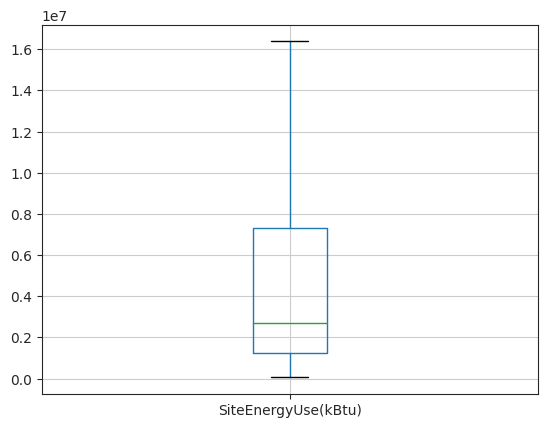

count    1.482000e+03
mean     8.880532e+06
std      3.187351e+07
min      5.713320e+04
25%      1.242400e+06
50%      2.701853e+06
75%      7.301812e+06
max      8.739237e+08
Name: SiteEnergyUse(kBtu), dtype: float64

In [20]:
y = data[pt.ENERGY_TARGET]
X_core = data.loc[:, core_fts]
X_core_with_additional = data.loc[:, [*core_fts, *additional_fts]]
Xs = [X_core, X_core_with_additional]

y.to_frame().boxplot(showfliers=False)
plt.show()
y.describe()

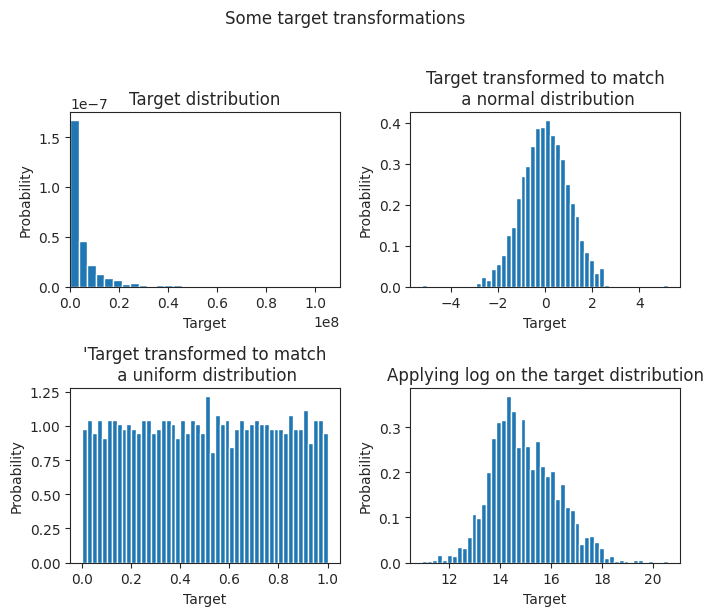

In [21]:
y_reshape = np.array(y).reshape(-1, 1)

# Transform target to match a normal distribution
qtn = QuantileTransformer(
    n_quantiles=100, output_distribution="normal", random_state=0
)
y_n = qtn.fit_transform(y_reshape)

# Transform target to match a uniform distribution
qtu = QuantileTransformer(
    n_quantiles=100, output_distribution="uniform", random_state=0
)
y_u = qtu.fit_transform(y_reshape)

# Transform target applying a log_transformer
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
y_log = log_transformer.fit_transform(y_reshape)


### Plots
f, axs = plt.subplots(2, 2, figsize=(7,6))
ax0, ax1 = axs[0]
ax2, ax3 = axs[1]
n_bins=50

ax0.hist(y, bins=n_bins*5, density=True)
ax0.set_xlim([0, 1.1e8])
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_n, bins=n_bins, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Target transformed to match\n a normal distribution")

ax2.hist(y_u, bins=n_bins, density=True)
ax2.set_ylabel("Probability")
ax2.set_xlabel("Target")
ax2.set_title("'Target transformed to match\n a uniform distribution")

ax3.hist(y_log, bins=n_bins, density=True)
ax3.set_ylabel("Probability")
ax3.set_xlabel("Target")
ax3.set_title("Applying log on the target distribution")

f.suptitle("Some target transformations", y=1.02)
plt.tight_layout()
plt.show()

It is interesting to observe that the target is similar in shape with the PropertyGFABuildings(s)

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Splitting into test and train sets

In [22]:
# X is to be equal to X_core or X_core_with_additional
X = X_core

test_size = 0.25
seed = 2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=test_size, random_state=seed
)

# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Defining metrics

In [23]:
### A dataframe of the chosen metrics with 3 attributes:
# - the sklearn name function;
# - the alias for some sklearn functions scoring parameter;
# - eventually some kwargs to pass to the function so it has the desired
# behavior.
metrics = pd.DataFrame(
    {
        "name": ["R2", "MAE", "RMSE", "RMLSE"],
        "func": [
            r2_score,
            mean_absolute_error,
            mean_squared_error,
            mean_squared_log_error,
        ],
        "scoring_alias": [
            "r2",
            "neg_mean_absolute_error",
            "neg_root_mean_squared_error",
            "neg_root_mean_squared_log_error",
        ],
        "kwargs": [
            None,
            None,
            dict([("squared", False)]),
            dict([("squared", False)]),
        ],
    }
).set_index("name")

# Not using RMSLE for now because I have some negative values.
metrics = metrics.iloc[:-1, :]
metrics

,func,scoring_alias,kwargs
name,,,
R2,<function r2_score at 0x7f9f706ae820>,r2,None
MAE,<function mean_absolute_error at 0x7f9f706ae3a0>,neg_mean_absolute_error,None
RMSE,<function mean_squared_error at 0x7f9f706ae550>,neg_root_mean_squared_error,{'squared': False}


In [24]:
def apply_score_func(metric, y_pred, y_true, precision=5):
    """ Compute the score according the 'metric' 
    
    'metric' must be a series of the metrics dataframe I made
    to regroup scoring aliases and scoring function of sklearn."""
    if metric.kwargs is not None:
        return round(metric.func(y_pred, y_true, **metric.kwargs), precision)
    else:
        return round(metric.func(y_pred, y_true), precision)

In [25]:
# Test previous function
a = [0.2, 0.5]
b = [0.25, 0.48]
apply_score_func(metrics.loc['R2'], a, b)

0.93556

# 6.  [&#9650;](#toc0_) <a id='toc6_'></a>Baseline

In [26]:
for i, m in metrics.iterrows():
    dummy = DummyRegressor(strategy="mean")
    ds.CV_evaluation(
        dummy, X_train, y_train, scoring=m.scoring_alias
    )
    print("-"*10)

DummyRegressor
Cross-validation evaluation results w.r.t the r2 metric:

    scores on folds: [-0.001 -0.006 -0.059 -0.    -0.002]
    mean score: -0.014
    std score deviation: 0.023
----------
DummyRegressor
Cross-validation evaluation results w.r.t the mean_absolute_error metric:

    scores on folds: [8769184.855 9148419.675 7228267.637 8774754.506 8178804.073]
    mean score: 8419886.149
    std score deviation: 671829.961
----------
DummyRegressor
Cross-validation evaluation results w.r.t the root_mean_squared_error metric:

    scores on folds: [23145019.346 22569959.069  9854008.152 31476496.543 13357420.716]
    mean score: 20080580.766
    std score deviation: 7684248.213
----------


# 7.  [&#9650;](#toc0_) <a id='toc7_'></a>Defining pre_processors

In [27]:
log_min_max = Pipeline(
    [
        ("log", log_transformer),
        ("scaler", MinMaxScaler(feature_range=(0, 1)))
    ]
)

# Excluding One-hot encoded features of the pre-processing (passthrough)
min_max_pre_processor = ColumnTransformer(
    transformers=[("scaler", MinMaxScaler(feature_range=(0, 1)), num_fts)],
    remainder="passthrough"
)

standard_pre_processor = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), num_fts)],
    remainder="passthrough"
)

mixed_log_min_max_pre_processor = ColumnTransformer(
    transformers=[
        ("log_scaler", log_min_max, [skewed_fts]),
        (
            "scaler",
            MinMaxScaler(feature_range=(0, 1)),
            list(set(num_fts) - set(skewed_fts))
         )
    ],
    remainder="passthrough"
)

# 8.  [&#9650;](#toc0_) <a id='toc8_'></a>Linear regressions

## 8.1.  [&#9650;](#toc0_) <a id='toc8_1_'></a>OLS minimization

### 8.1.1.  [&#9650;](#toc0_) <a id='toc8_1_1_'></a>Without target transformation

#### 8.1.1.1.  [&#9650;](#toc0_) <a id='toc8_1_1_1_'></a>With a simple MinMaxScaler for all numerical input features

In [28]:
# Define the evaluation metric 
metric = metrics.loc['R2']

pipe = Pipeline(
    [
        ("pre_processor", min_max_pre_processor),
        ("regressor", LinearRegression()),
    ]
)
display(pipe)

_ = ds.CV_evaluation(
    pipe, X_train, y_train, k=5,
    scoring=metric.scoring_alias, seed=0
)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['PropertyGFABuilding(s)',
                                                   'Age', 'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'SteamUseProportion',
                                                   'ElectricityProportion',
                                                   'NaturalGasProportion'])])),
                ('regressor', LinearRegression())])

Pipeline
Cross-validation evaluation results w.r.t the r2 metric:

    scores on folds: [0.531 0.186 0.865 0.488 0.691]
    mean score: 0.552
    std score deviation: 0.226



Test score :
    R2 0.85478


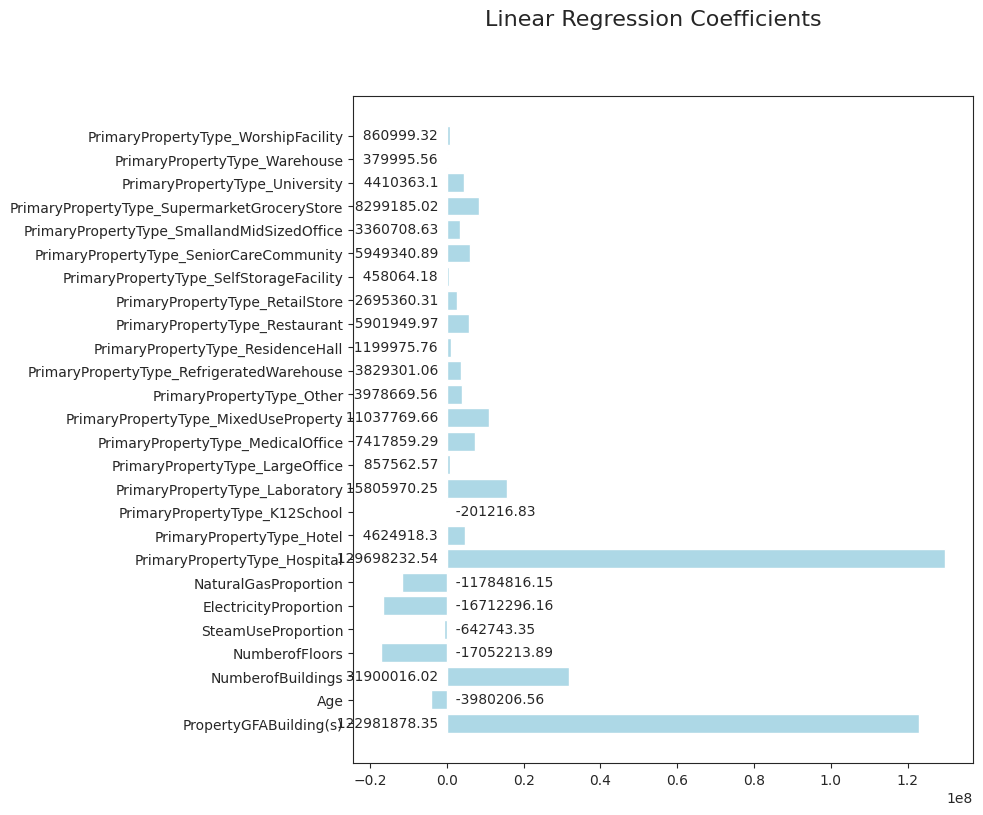

In [30]:
pipe.fit(X_train, y_train)
print("\nTest score :")
ds.score(pipe, metric, X_test, y_test)
ds.linearRegressionSummary(pipe["regressor"], X.columns)

The regression has high variance and coefficient have huge values. 
It needs to be regularized.

#### 8.1.1.2.  [&#9650;](#toc0_) <a id='toc8_1_1_2_'></a>With a simple Standard scaler for all numerical input features  and no target transformation

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['PropertyGFABuilding(s)',
                                                   'Age', 'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'SteamUseProportion',
                                                   'ElectricityProportion',
                                                   'NaturalGasProportion'])])),
                ('regressor', LinearRegression())])

Pipeline
Cross-validation evaluation results w.r.t the r2 metric:

    scores on folds: [0.531 0.186 0.865 0.488 0.691]
    mean score: 0.552
    std score deviation: 0.226

Test score :
    R2 0.85478


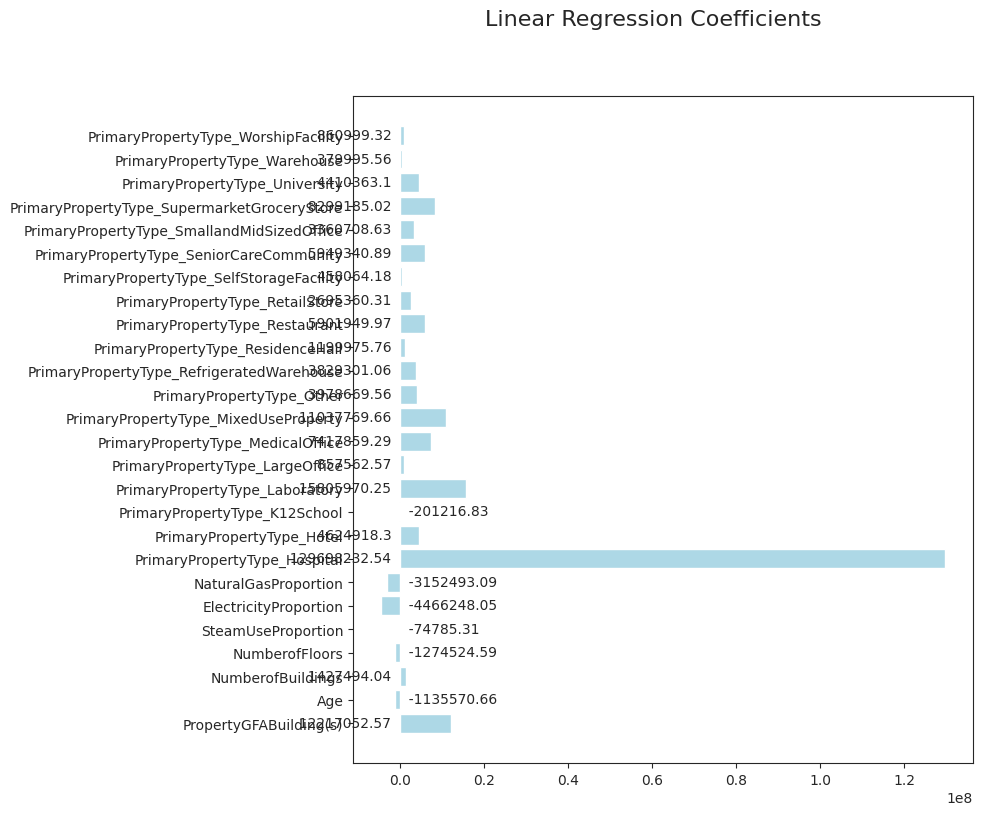

In [31]:
pipe = Pipeline(
    [
        ("pre_processor", standard_pre_processor),
        ("regressor", LinearRegression()),
    ]
)
display(pipe)

ds.CV_evaluation(
    pipe, X_train, y_train, scoring=metric.scoring_alias, seed=0
)

pipe.fit(X_train, y_train)
print("\nTest score :")
ds.score(pipe, metric, X_test, y_test)
ds.linearRegressionSummary(pipe["regressor"], X.columns)

Same with a different initial scaling

#### 8.1.1.3.  [&#9650;](#toc0_) <a id='toc8_1_1_3_'></a>With a log-transformation on skewed input prior to MinMaxScaler

In [37]:
pipe = Pipeline(
    [
        ("log_min_max_pre_processor", mixed_log_min_max_pre_processor),
        ("regressor", LinearRegression()),
    ]
)
display(pipe)

# ds.CV_evaluation(
#     pipe, X_train, y_train, scoring=metric.scoring_alias, seed=0
# )

pipe.fit(X_train, y_train)
print("\nTest score :")
ds.score(pipe, metric, X_test, y_test)
ds.linearRegressionSummary(pipe["regressor"], X.columns)

Pipeline(steps=[('log_min_max_pre_processor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_scaler',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [Index(['PropertyGFABuilding(s)', 'NumberofBuildings', 'NumberofFloors',
       'SteamUseProportion'],
      dtype='object')]),
                                                 ('scaler', MinMaxScaler(),
                                                  ['Age',
                                                   'ElectricityProportion',
                                                   'NaturalGasProportion'])])),
                ('regressor', LinearRegression())])

TypeError: unhashable type: 'Index'

### With target transformation

In [ ]:
pipe = Pipeline(
    [
        ("scaler", MinMaxScaler(feature_range=(0, 1))),
        ("linreg", LinearRegression()),
    ]
)

tt = TransformedTargetRegressor(
    regressor=pipe,
    transformer=qtn
)

ds.CV_evaluation(tt, X_train, y_train, k=5, seed=0)

In [ ]:

tt.fit(X_train, y_train)
print("\nTest score :")
ds.score(pipe, X_test, y_test)
ds.linearRegressionSummary(pipe["linreg"], X.columns)


## 8.2.  [&#9650;](#toc0_) <a id='toc8_2_'></a>With target transformation

## 8.3.  [&#9650;](#toc0_) <a id='toc8_3_'></a>Lasso

In [106]:
pipe = Pipeline(
    [
        ("scaler", MinMaxScaler(feature_range=(0, 1))),
        ("lasso", Lasso(random_state=0, max_iter=100_000)),
    ]
)
scoring = "r2"
alphas = np.logspace(4, 5, 100)
tuned_parameters = [{"lasso__alpha": alphas}]
n_folds = 5

search = GridSearchCV(
    pipe, param_grid=tuned_parameters, scoring=scoring, cv=n_folds
)
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('lasso',
                                        Lasso(max_iter=100000,
                                              random_state=0))]),
             param_grid=[{'lasso__alpha': array([ 10000.        ,  10235.31021899,  10476.1575279 ,  10722.6722201 ,
        10974.98765493,  11233.24032978,  11497.56995398,  11768.11952435,
        12045.03540259,  12328.46739442,  12618.56883066,  12915.49665015,
        13219.41148466,  13530.4777...
        58570.20818057,  59948.42503189,  61359.07273413,  62802.91441834,
        64280.73117284,  65793.32246576,  67341.50657751,  68926.1210435 ,
        70548.02310719,  72208.09018385,  73907.22033526,  75646.33275546,
        77426.36826811,  79248.28983539,  81113.08307897,  83021.7568132 ,
        84975.34359086,  86974.90026178,  89021.5085445 ,  91116.27561155,
        93260.33468832,  95454.84566618,  97700.99572992, 100000.        ])}],
             scoring='r2')

<IPython.core.display.Javascript object>

In [107]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.591):
{'lasso__alpha': 73907.22033525775}


<IPython.core.display.Javascript object>

In [110]:
pipe = Pipeline(
    [
        ("scaler", MinMaxScaler(feature_range=(0, 1))),
        (
            "lasso",
            Lasso(
                alpha=search.best_params_["lasso__alpha"],
                random_state=0,
                max_iter=100_000,
            ),
        ),
    ]   
)
ds.CV_evaluation(pipe, X_train, y_train, k=n_folds)


Pipeline
Cross-validation evaluation results w.r.t the r2 metric:

    scores on folds: [0.73476646 0.79178511 0.54234681 0.17274774 0.64000278]
    mean score: 0.5763297798043536
    std score deviation: 0.21891127624244267


(array([0.73476646, 0.79178511, 0.54234681, 0.17274774, 0.64000278]),
 0.5763297798043536,
 0.21891127624244267)

<IPython.core.display.Javascript object>


Test score :
    R2 0.8311816032246491


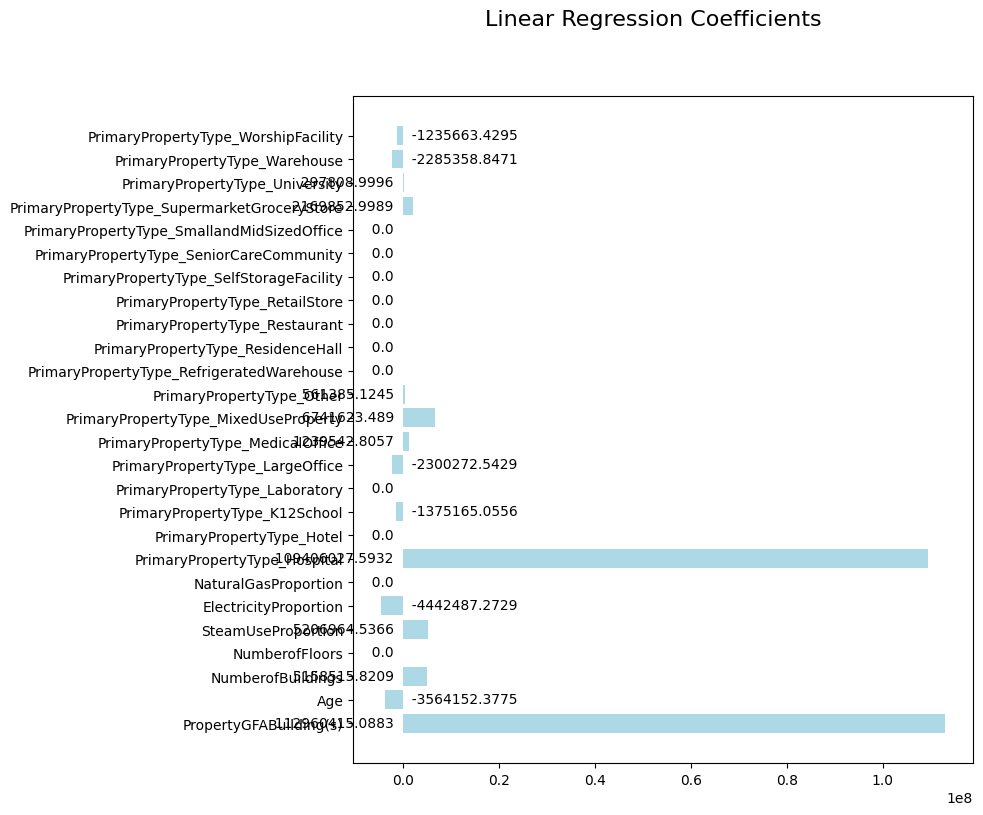

<IPython.core.display.Javascript object>

In [111]:
pipe.fit(X_train, y_train)
print("\nTest score :")
ds.score(pipe, X_test, y_test)
ds.linearRegressionSummary(pipe["lasso"], X.columns)


## 8.4.  [&#9650;](#toc0_) <a id='toc8_4_'></a>Ridge

In [114]:
pipe = Pipeline(
    [
        ("scaler", MinMaxScaler(feature_range=(0, 1))),
        ("ridge", Ridge(random_state=0, max_iter=100_000)),
    ]
)

alphas = np.logspace(-1, 0, 100)
tuned_parameters = [{"ridge__alpha": alphas}]
n_folds = 5

clf = GridSearchCV(pipe, param_grid=tuned_parameters, scoring="r2", cv=n_folds)
clf.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)


Best parameter (CV score=0.580):
{'ridge__alpha': 0.6428073117284322}


<IPython.core.display.Javascript object>

In [116]:
pipe = Pipeline(
    [
        ("scaler", MinMaxScaler(feature_range=(0, 1))),
        (
            "ridge",
            Ridge(
                alpha=clf.best_params_["ridge__alpha"],
                random_state=0,
                max_iter=100_000,
            ),
        ),
    ]
)
ds.CV_evaluation(pipe, X_train, y_train)

Pipeline
Cross-validation evaluation results w.r.t the r2 metric:

    scores on folds: [0.74499437 0.79141409 0.45293961 0.17725448 0.63777682]
    mean score: 0.5608758742845944
    std score deviation: 0.22440002783023155


(array([0.74499437, 0.79141409, 0.45293961, 0.17725448, 0.63777682]),
 0.5608758742845944,
 0.22440002783023155)

<IPython.core.display.Javascript object>

In [117]:
pipe

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ridge',
                 Ridge(alpha=0.6428073117284322, max_iter=100000,
                       random_state=0))])

<IPython.core.display.Javascript object>


Test score :
    R2 0.8769438368643867


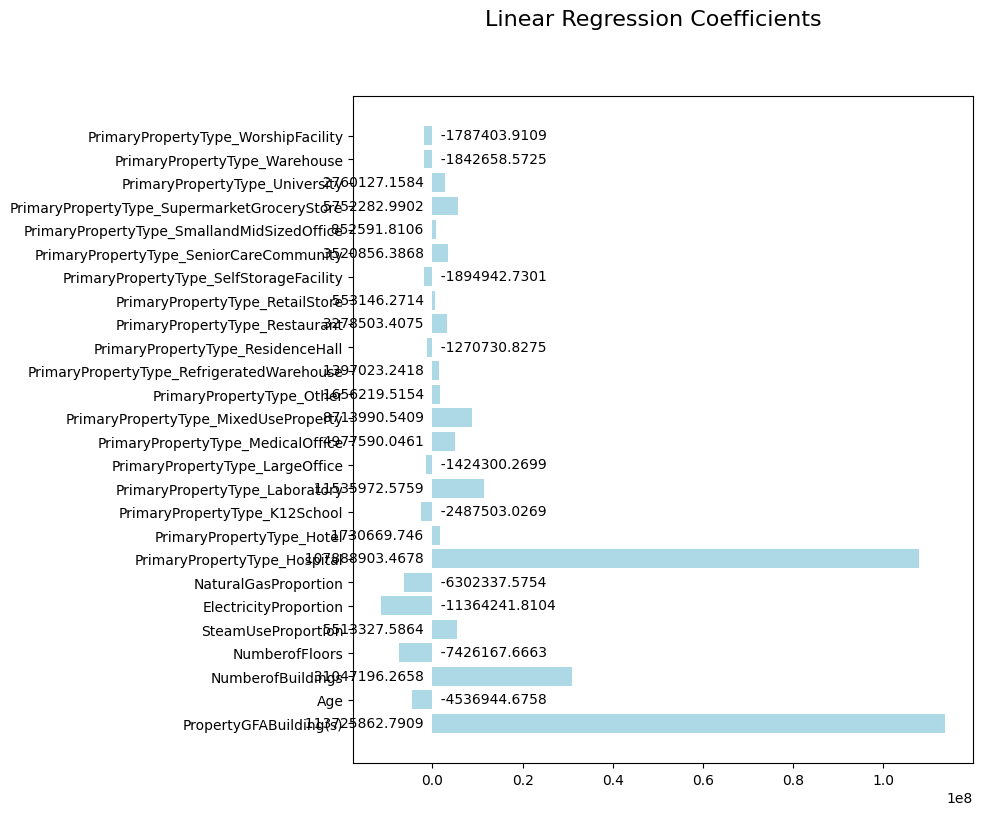

<IPython.core.display.Javascript object>

In [118]:
pipe.fit(X_train, y_train)
print("\nTest score :")
ds.score(pipe, X_test, y_test)
ds.linearRegressionSummary(pipe["ridge"], X.columns)


## 8.5.  [&#9650;](#toc0_) <a id='toc8_5_'></a>Elastic-net

In [1]:
pipe = Pipeline(
    [
        ("scaler", MinMaxScaler(feature_range=(0, 1))),
        ("elastic_net", ElasticNet(random_state=0, max_iter=100_000)),
    ]
)

grid = dict()
grid['elastic_net__alpha'] = np.logspace(2, 10, 5)
grid['elastic_net__l1_ratio'] = np.linspace(0, 1, 5)

search = GridSearchCV(pipe, grid, scoring='r2', cv=5)
# perform the search
results = search.fit(X_train, y_train)

NameError: name 'Pipeline' is not defined

# 9.  [&#9650;](#toc0_) <a id='toc9_'></a>Model evaluation

In [46]:
seed = 0
### A dataframe of the chosen Regressors with 3 attributes:
# - the sklearn Class;
# - eventually some kwargs to pass to the function so it has the desired
# behavior.
# - the params_grid for CV evaluation.
regressors = pd.DataFrame(
    {
        "name": [
            "linear_regression",
            "lasso",
            "ridge",
            "elastic_net",
            "huber",
            "knn",
            "random_forest",
            "xgboost",
        ],
        "regressor": [
            LinearRegression,
            Lasso,
            Ridge,
            ElasticNet,
            HuberRegressor,
            KNeighborsRegressor,
            RandomForestRegressor,
            np.NAN,
        ],
        "kwargs": [
            None,
            {"random_state": seed, "max_iter": 100_000},
            {"random_state": seed, "max_iter": 100_000},
            None,
            None,
            None,
            None,
            None,
        ],
        "params_grid": [
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
    }
).set_index("name")

### A dataframe for the chosen pre_processors with 2 attributes:
# - The sklearn class;
# - Eventual kwargs to pass to the class.
pre_processors = pd.DataFrame(
    columns=["name", "pre_processor", "kwargs"]
).set_index("name")
# Extended line by line for easier reading and future modification.
pre_processors.loc["minmax"] = [MinMaxScaler, {"feature_range": (0, 1)}]
pre_processors.loc["standard"] = [StandardScaler, None]
pre_processors.loc["robust"] = [RobustScaler, None]


target_processors = {
    "identity": identity_transformer,
    "log_transformer": log_transformer,
}




display(regressors)
display(pre_processors)
display(metrics)

,regressor,kwargs,params_grid
name,,,
linear_regression,<class 'sklearn.linear_model._base.LinearRegression'>,None,None
lasso,<class 'sklearn.linear_model._coordinate_descent.Lasso'>,"{'random_state': 0, 'max_iter': 100000}",None
ridge,<class 'sklearn.linear_model._ridge.Ridge'>,"{'random_state': 0, 'max_iter': 100000}",None
elastic_net,<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>,None,None
huber,<class 'sklearn.linear_model._huber.HuberRegressor'>,None,None
knn,<class 'sklearn.neighbors._regression.KNeighborsRegressor'>,None,None
random_forest,<class 'sklearn.ensemble._forest.RandomForestRegressor'>,None,None
xgboost,NaN,None,None


,pre_processor,kwargs
name,,
minmax,<class 'sklearn.preprocessing._data.MinMaxScaler'>,"{'feature_range': (0, 1)}"
standard,<class 'sklearn.preprocessing._data.StandardScaler'>,None
robust,<class 'sklearn.preprocessing._data.RobustScaler'>,None


,func,scoring_alias,kwargs
name,,,
R2,<function r2_score at 0x7f91d0e1b820>,r2,None
MAE,<function mean_absolute_error at 0x7f91d0e1b3a0>,neg_mean_absolute_error,None
RMSE,<function mean_squared_error at 0x7f91d0e1b550>,neg_root_mean_squared_error,{'squared': False}
RMLSE,<function mean_squared_log_error at 0x7f91d0e1b5e0>,neg_root_mean_squared_log_error,{'squared': False}


<IPython.core.display.Javascript object>

In [178]:
# testing rmse
met = "rmse"
pred = pipe.predict(X_train)
tfunc = metrics[met]["func"]
tkwargs = metrics[met]["kwargs"]
if tkwargs is not None:
    score = tfunc(y_train, pred, **tkwargs)
else:
    score = tfunc(y_train, pred)
score


14747234.34862928

In [47]:
# Compute the cartesian product
import itertools

combinations = list(
    itertools.product(
        regressors.index,
        pre_processors.index,
        # target_processors.keys(),
        metrics.index,
    )
)

idx = pd.MultiIndex.from_tuples(
    combinations,
    names=[
        "regressor",
        "pre_processor",
        #    "target_processor",
        "metric",
    ],
)

cols = [
    "CV_train_score_mean",
    "CV_train_score_std",
    "computation_time",
    "hyperparameters",
    "CV_scores" "test_score",
]

m = idx.shape[0]
n = len(cols)
x = np.zeros(m * n).reshape(m, n)

df = pd.DataFrame(x, index=idx, columns=cols)
df


CV_train_score_mean  \
regressor         pre_processor metric                        
linear_regression minmax        R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
                  standard      R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
                  robust        R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
lasso             minmax        R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
                  standard      R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
                  robust        R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
ridge             minmax        R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
                  standard      R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
                  robust        R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
elastic_net       minmax        R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
                  standard      R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
                  robust        R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
huber             minmax        R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
                  standard      R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
                  robust        R2                      0.0   
                                MAE                     0.0   
                                RMSE                    0.0   
                                RMLSE                   0.0   
knn               minmax        R2                      0.0   
                                MAE                     0.0   
        

<IPython.core.display.Javascript object>

In [128]:
df.loc[("lasso", "minmax", "none", "r2"), "hyperparameters"] = 5


/tmp/ipykernel_4942/962172260.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('lasso','minmax','none', 'r2'), 'hyperparameters'] = 5


In [117]:
with pd.option_context("display.multi_sparse", False):
    display(df)


,,,,CV_train_score_mean,CV_train_score_std,computation_time,hyperparameters,CV_scorestest_score
regressor,preprocessor,target_processor,metric,,,,,
linear_regression,minmax,none,r2,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,none,mae,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,none,rmse,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,none,rmsle,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,log_transformation,r2,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,log_transformation,mae,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,log_transformation,rmse,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,log_transformation,rmsle,0.0,0.0,0.0,0.0,0.0
linear_regression,standard,none,r2,0.0,0.0,0.0,0.0,0.0


In [119]:
df.index.levels


FrozenList([['elastic_net', 'huber', 'knn', 'lasso', 'linear_regression', 'random_forest', 'ridge', 'xgboost'], ['minmax', 'robust', 'standard'], ['log_transformation', 'none'], ['mae', 'r2', 'rmse', 'rmsle']])

In [124]:
df.loc[("ridge", "minmax"), :]


/tmp/ipykernel_4942/949409612.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('ridge','minmax'), :]


CV_train_score_mean  CV_train_score_std  \
target_processor   metric                                            
none               r2                      0.0                 0.0   
                   mae                     0.0                 0.0   
                   rmse                    0.0                 0.0   
                   rmsle                   0.0                 0.0   
log_transformation r2                      0.0                 0.0   
                   mae                     0.0                 0.0   
                   rmse                    0.0                 0.0   
                   rmsle                   0.0                 0.0   

                           computation_time  hyperparameters  \
target_processor   metric                                      
none               r2                   0.0              0.0   
                   mae                  0.0              0.0   
                   rmse                 0.0              0.0   
                   rmsle                0.0              0.0   
log_transformation r2                   0.0              0.0   
                   mae                  0.0              0.0   
                   rmse                 0.0              0.0   
                   rmsle                0.0              0.0   

                           CV_scorestest_score  
target_processor   metric                       
none               r2                      0.0  
                   mae                     0.0  
                   rmse                    0.0  
                   rmsle                   0.0  
log_transformation r2                      0.0  
                   mae                     0.0  
                   rmse                    0.0  
                   rmsle                   0.0

In [126]:
# extract all with minmax (drop_level to keep it written)
df.xs("minmax", level="preprocessor", drop_level=False)


CV_train_score_mean  \
regressor         preprocessor target_processor   metric                        
linear_regression minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
lasso             minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
ridge             minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
elastic_net       minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
huber             minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
knn               minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
random_f

In [139]:
idx = df.index.get_level_values("pre_processor")[0]


KeyError: 'Level pre_processor not found'

In [ ]:
for n, idx in enumerate(df.index):
    Pipe = Pipeline(
        [
            ('pre_processor', idx.get_level_values('preprocessor')
        ]
    )

In [138]:
idx.get_level_values("preprocessor")


AttributeError: 'tuple' object has no attribute 'get_level_values'

In [142]:
a = {"a": 2, "b": 3}


In [179]:
a.values()


dict_values([2, 3])

In [149]:
dict([("squared", False)])


{'squared': False}

In [150]:
X_train


,PropertyGFABuilding(s),Age,NumberofBuildings,NumberofFloors,SteamUseProportion,ElectricityProportion,NaturalGasProportion,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K12School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_LargeOffice,PrimaryPropertyType_MedicalOffice,PrimaryPropertyType_MixedUseProperty,PrimaryPropertyType_Other,PrimaryPropertyType_RefrigeratedWarehouse,PrimaryPropertyType_ResidenceHall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_RetailStore,PrimaryPropertyType_SelfStorageFacility,PrimaryPropertyType_SeniorCareCommunity,PrimaryPropertyType_SmallandMidSizedOffice,PrimaryPropertyType_SupermarketGroceryStore,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_WorshipFacility
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,
163,61156,17,1,4,0.0,0.74,0.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,759392,54,1,41,0.3,0.68,0.02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
756,78920,94,1,4,0.0,0.86,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23689,24224,66,1,2,0.0,0.55,0.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27494,36982,44,1,1,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,51374,23,1,2,0.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
514,131387,26,1,1,0.0,0.88,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,52298,102,1,3,0.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


AttributeError: 'list' object has no attribute 'get'

In [180]:
metrics


{'r2': {'scoring': 'r2',
  'func': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)>,
  'kwargs': None},
 'mae': {'scoring': 'neg_mean_absolute_error',
  'func': <function sklearn.metrics._regression.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
  'kwargs': None},
 'rmse': {'scoring': 'neg_root_mean_squared_error',
  'func': <function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>,
  'kwargs': {'squared': False}}}

In [181]:
metrics["r2"]


{'scoring': 'r2',
 'func': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)>,
 'kwargs': None}

In [186]:
a, b, c = metrics["rmse"].values()


In [187]:
a


'neg_root_mean_squared_error'

In [188]:
b


<function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>

In [189]:
c


{'squared': False}